# 1. Introduction

Hello, my name is Seyong Ryoo, a student taking a master's degree in Statistics and Data Science at KU Leuven. With three weeks left before the next semester, I decided to do Kaggle projects to put what I learned over the year into practice. Titanic is my first kaggle project and I think this will be a good opportunity to review the classifiers I've learned so far and apply them to the actual data.

What is required in this competition is to predict whether the passengers not included in the training data with the model trained with training samples survived or not using our model.

We start by loading necessary libraries.

In [1]:
# Data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing and machine learning
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# 2. Load Data

In [2]:
X_train = pd.read_csv('data/train.csv', index_col = 'PassengerId')
X_test = pd.read_csv('data/test.csv', index_col = 'PassengerId')

# Obtain target and predictors
y_train = X_train['Survived']
X_train.drop('Survived', axis = 1, inplace = True)

In [3]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X_train.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

# 3. Preprocessing

Looking at the training data set, I decided to drop variables that are unlikely to help predict survival. 
- We use `PassengerId` as the index of the data.
- From the variable `Name`, we can infer passengers' social and economic status and think that the higher their status, the higher the probability of survival, but I think the correlation is very small. `
- `Ticket` and `Cabin` are also dropped because I think they do not contain important information.

In [5]:
# Drop column 'Ticket' and 'Cabin'
X_train.drop(['Ticket', 'Cabin', 'Name'], axis = 1, inplace = True)
X_test.drop(['Ticket', 'Cabin', 'Name'], axis = 1, inplace = True)

I created a new variable called `Family` that counts the total number of family members on board by adding `Parch` and `SibSp`.

In [6]:
X_train['Family'] = X_train['Parch'] + X_train['SibSp']
X_train.drop(['Parch', 'SibSp'], axis = 1, inplace = True)

X_test['Family'] = X_test['Parch'] + X_test['SibSp']
X_test.drop(['Parch', 'SibSp'], axis = 1, inplace = True)

In the case of missing data, the observations were replaced with the median value of the variable if it was a number and the mode if it was a category.

Next, I transformed the data to have an appropriate representation of them for model fitting. The numeric features were standardized with zero mean and unit variance. For the categorical variables, I converted them to integers by using one-hot encoding.

In [7]:
# Number of missing values in each column of training data
X_train.isna().sum()

Pclass        0
Sex           0
Age         177
Fare          0
Embarked      2
Family        0
dtype: int64

In [8]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, X_train.select_dtypes(exclude = 'object').columns.tolist()),
    ('cat', categorical_transformer, X_train.select_dtypes(include = 'object').columns.tolist())
])

# 4. Visualization

I visualized the data before applying it to various classification models. This made it easy to see at a glance which variables were largely related to survival.

1. Sex

The bar graph below shows that female passengers had a higher survival probability than male passengers.

Text(0.5, 1.0, 'Survival rate based on gender')

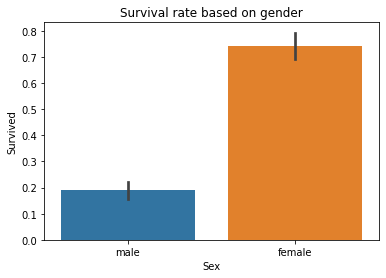

In [9]:
sns.barplot(x = 'Sex', y = y_train, data = X_train)
plt.title('Survival rate based on gender')

2. Class

The `Pclass` variable also seems to be deeply related to the survival rate because, as shown in the graph below, the survival rate of those who boarded the first class is higher than that of second and third class passengers.

Text(0.5, 1.0, 'Survival rate based on class')

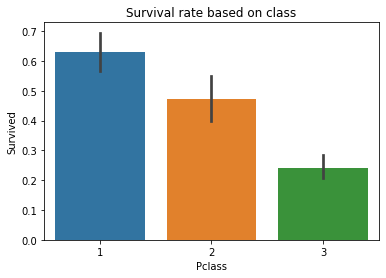

In [10]:
sns.barplot(x = 'Pclass', y = y_train, data = X_train)
plt.title('Survival rate based on class')

3. Port of Embarkation

People aboard Cherbourg were more likely to survive than passengers aboard the other two places (Queenstown and Southampton).

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

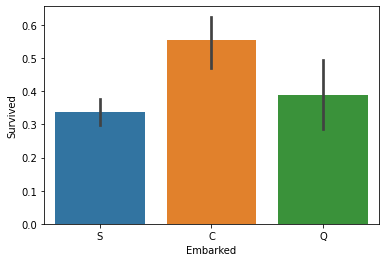

In [11]:
sns.barplot(x = X_train['Embarked'].fillna(X_train['Embarked'].mode()), y = y_train)

# 5. Model

Now it's time to apply various classifiers to the data. The parameters of each model were optimized through grid search cross-validation. Then, I select the best model for submission by comparing accuracy scores of the models.

## 1. Linear Discriminant Analysis (LDA) Classifier

For classification of two classes, LDA finds the best linear combination of variables. This linear combination maximizes the distance between classes and minimizes the variance within the class.

In [12]:
lda = LinearDiscriminantAnalysis()
param_grid_lda = [{'model__solver': ['svd', 'lsqr']}]
pipeline_lda = Pipeline(steps = [('preprocessor', preprocessor), ('model', lda)])
grid_lda = GridSearchCV(pipeline_lda, param_grid_lda, cv = 5, scoring = 'accuracy')
grid_lda.fit(X_train, y_train)
print(grid_lda.best_params_, grid_lda.best_score_)

{'model__solver': 'svd'} 0.7946142740568701


## 2. Quadratic Discriminant Analysis (QDA) Classifier

QDA derives a quadratic decision boundary unlike LDA because it does not assume that all classes of the dependent variable have the same covariance structure.

In [13]:
qda = QuadraticDiscriminantAnalysis(tol = 1*10^-10)
param_grid_qda = [{'model__reg_param': [0, 0.0001, 0.001, 0.01, 0.05, 0.1]}]
pipeline_qda = Pipeline(steps = [('preprocessor', preprocessor), ('model', qda)])
grid_qda = GridSearchCV(pipeline_qda, param_grid_qda, cv = 5, scoring = 'accuracy')
grid_qda.fit(X_train, y_train)
print(grid_qda.best_params_, grid_qda.best_score_)

{'model__reg_param': 0.05} 0.8024919967359236


## 3. Logistic Regression

We model the probability of a binary dependent variable given data using logistic function of the linear predictor and the decision boundary produced by logistic regression is linear.

In [14]:
lr = LogisticRegression(random_state = 0, n_jobs = -1)
param_grid_lr = [{'model__solver': ['sag', 'saga'],
                  'model__C': [0.01, 0.1, 1, 5],
                  'model__max_iter': [50, 100, 500, 1000],
                  'model__class_weight': [None, 'balanced']}]
pipeline_lr = Pipeline(steps = [('preprocessor', preprocessor), ('model', lr)])
grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv = 5, scoring = 'accuracy')
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_, grid_lr.best_score_)

{'model__C': 0.1, 'model__class_weight': None, 'model__max_iter': 50, 'model__solver': 'sag'} 0.7991212102190698


## 4. Random Forest Classifier

Random forest classifier is an approach that helps improve the predictive performance of decision trees. It does so by randomly selecting a subset of features when building a tree. Then, the trees may be less correlated, which makes the variance smaller and avoids over-fitting.

In [15]:
rf = RandomForestClassifier(random_state = 0, n_jobs = -1)
param_grid_rf = [{'model__n_estimators': [5, 10, 50, 100],
                 'model__criterion': ['gini', 'entropy'],
                 'model__max_depth': [1,  5, 10, None],
                 'model__max_features': ['auto', 'log2', None],
                 'model__max_samples': [None, 1, 2, 3, 4, 5 ]}]
pipeline_rf = Pipeline(steps = [('preprocessor', preprocessor), ('model', rf)])
grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv = 5, scoring = 'accuracy')
grid_rf.fit(X_train, y_train)
print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_features': None, 'model__max_samples': None, 'model__n_estimators': 50}
0.8339212855439081


## 5. Gaussian Naive Bayes Classifier

The classifier computes the poster probability and makes predictions based on the Bayes theorem assuming that the variables of the data follow a normal distribution.

In [16]:
nb = GaussianNB()
pipeline_nb = Pipeline(steps = [('preprocessor', preprocessor), ('model', nb)])
gnb_score = cross_val_score(pipeline_nb, X_train, y_train, cv = 5, scoring = 'accuracy').mean()
print(gnb_score)

0.7867804908668633


## 6. K-Nearest Neighbors (KNN) Classifier

The KNN classifier identifies the K points in the data closest to a point to classify and calculates the conditional probability for a class as the fraction of points in the set of K identified points whose response values are equal to the class. Then, it classifies the point to the class that has the highest conditional probability.

In [17]:
knn = KNeighborsClassifier(n_jobs = -1)
param_grid_knn = [{"model__n_neighbors": [1, 10, 50, 100, 200, 300, 400, 500], 
                   "model__weights": ["uniform","distance"],
                   "model__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
                   "model__metric": ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]
pipeline_knn = Pipeline(steps = [('preprocessor', preprocessor), ('model', knn)])
grid_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv = 5, scoring = 'accuracy')
grid_knn.fit(X_train, y_train)
print(grid_knn.best_params_)
print(grid_knn.best_score_)

{'model__algorithm': 'auto', 'model__metric': 'manhattan', 'model__n_neighbors': 10, 'model__weights': 'uniform'}
0.8193019898311468


## 7. SVM Classifier

The SVM maximizes the distance between the decision boudary and the observations of the classes adjacent to it in the classification task. For better generalization, the algorithm allows misclassification by placing some observations in different classes during the training process.

In [18]:
svm = SVC(random_state = 0)
param_grid_svm = [{'model__C': [0.01, 0.1, 1, 10],
                   'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                   'model__gamma': ['auto', 'scale']}]
pipeline_svm = Pipeline(steps = [('preprocessor', preprocessor), ('model', svm)])
grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv = 5, scoring = 'accuracy')
grid_svm.fit(X_train, y_train)
print(grid_svm.best_params_)
print(grid_svm.best_score_)

{'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
0.8316364321134893


## 8. Gradient Boosting Classifier

Gradient Boosting is another approach to improve the predictive power of classification trees. Starting from a leaf which is e.g. the log of odds of the independent variable, we compute residuals, the difference between observed values and predictions. Then, a tree is built in order to predict the residuals. It continues building trees subsequently until the maximum number of trees specified is reached or the residuals are very small.

In [19]:
gb = GradientBoostingClassifier(random_state = 0)
param_grid_gb = [{'model__loss': ['deviance', 'exponential'],
                 'model__learning_rate': [0.001, 0.01, 0.1],
                 'model__n_estimators':  [10, 50, 100, 1000],
                 'model__criterion': ['friedman_mse', 'mse'],
                 'model__max_depth': [1, 3, 5, 10],
                 'model__max_features': [None, 'auto', 'sqrt', 'log2']}]

pipeline_gb = Pipeline(steps = [('preprocessor', preprocessor), ('model', gb)])
grid_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv = 5, scoring = 'accuracy')
grid_gb.fit(X_train, y_train)
print(grid_gb.best_params_)
print(grid_gb.best_score_)

{'model__criterion': 'friedman_mse', 'model__learning_rate': 0.01, 'model__loss': 'deviance', 'model__max_depth': 3, 'model__max_features': None, 'model__n_estimators': 1000}
0.8350386039796623


## 9. Multi-Layer Perceptron (MLP) Classifier

The MLP is a class of artificial neural network that tries to mimic the human brain and approximate the relationship between a set of features and the independent variable by using backpropagation. It is composed of multiple layers including the input and output layer, which allows to model non-linearly separable data.

In [20]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

mlp = MLPClassifier(random_state = 0, solver = 'lbfgs')
param_grid_mlp = [{'model__hidden_layer_sizes': [(1,), (3,), (5,), (7,), (10,)],
                   'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
                   'model__alpha': [0.001, 0.01, 0.1],
                   'model__max_iter': [1000, 5000, 10000]}]

pipeline_mlp = Pipeline(steps = [('preprocessor', preprocessor), ('model', mlp)])
grid_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv = 5, scoring = 'accuracy', refit = True)
grid_mlp.fit(X_train, y_train)
print(grid_mlp.best_params_)
print(grid_mlp.best_score_)

{'model__activation': 'relu', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (7,), 'model__max_iter': 1000}
0.8204067541271733


In [21]:
pd.DataFrame([grid_lda.best_score_, grid_qda.best_score_, grid_lr.best_score_, grid_rf.best_score_, gnb_score, grid_knn.best_score_,
              grid_svm.best_score_, grid_gb.best_score_, grid_mlp.best_score_], 
             index = ['LDA', 'QDA', 'Logistic regression', 'Random Forest', 'Gaussian Naive Bayes', 'KNN', 'SVM', 'Gradient Boosting', 'MLP'],
             columns = ['Accuracy'])

,Accuracy
LDA,0.794614
QDA,0.802492
Logistic regression,0.799121
Random Forest,0.833921
Gaussian Naive Bayes,0.786780
KNN,0.819302
SVM,0.831636
Gradient Boosting,0.835039
MLP,0.820407


In [22]:
submission = pd.DataFrame({'Survived': grid_gb.predict(X_test)}, index = X_test.index)
submission.to_csv('submission_gb.csv')